# Section 1: Input Processing

In [7]:
#!pip install bertopic[all] sentence-transformers

In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import seaborn as sns
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import string
from scipy.optimize import minimize
import sklearn.linear_model as lm
from sklearn.metrics import r2_score
import torch


## Defining Functions

In [9]:
def load_data(filename):
  """
    Load data from a CSV file using pandas
    Args:
    filename: Enter filename as str (include quotations)
  """
  try:
    df = pd.read_csv(filename)
    return df
  except FileNotFoundError: # important to add to deal with path errors
    print("File not found. Check file path.")
  except csv.Error as e: # csv related errors
    print(f"CSV error: {e}")
  except Exception as e: # all other errors
    print(f"An unexpected error occurred: {e}")


def load_data_from_url(url):
    """
    Loads csv/xlsx data from a URL using pandas, requests, and BytesIO
    Args:
    filename: Enter filename as str (include quotations)
    """
    # Ensure we're using the raw file URL
    if "blob" in url:
        url = url.replace("blob/", "raw/")
    # Download the file
    response = requests.get(url)
    if response.status_code == 200: # if successfully dowloaded
        content = BytesIO(response.content)
        file_extension = url.split('.')[-1].lower() # extract extensions
        # Read file based on extension
        if file_extension in ['xls', 'xlsx']: # if xls
            return pd.read_excel(content, engine="openpyxl" if file_extension == "xlsx" else "xlrd") # use read_excel
        elif file_extension == 'csv': # if csv
            return pd.read_csv(content)
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")
    else:
        raise ValueError(f"Failed to download the file. Status code: {response.status_code}")

# Function to calculate h-index for each author
def calculate_h_index(citations):
    # Sort citations in descending order
    sorted_citations = sorted(citations, reverse=True)

    # Calculate the h-index: largest h where h papers have >= h citations
    h_index = 0
    for i, citation in enumerate(sorted_citations):
        if citation >= i + 1:
            h_index = i + 1
        else:
            break
    return h_index



## Data Ingestion and Processing

In [10]:
# unique data from API
df=load_data('output_matches_new.csv')
# 2024 data compiled earlier
data_24 =load_data_from_url("https://github.com/dingkaihua/fsrdc-external-census-projects/blob/master/ResearchOutputs.xlsx")

In [11]:
df.head(n=2)

,ProjID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectYearStarted,ProjectYearEnded,ProjectPI,OutputTitle,OutputType,OutputStatus,...,year,publication_date,cited_by_count,authors,affiliations,topics,OutputVenue,OutputMonth,OutputBibliography,matched_dataset_terms
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,article,published,...,2019,2019-06-10,1,Abigail M. Cooke; Thomas Kemeny; David L. Rigby,"University at Buffalo, State University of New...",Employment and Welfare Studies; Labor market d...,Industrial Relations A Journal of Economy and ...,6,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",True
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,preprint,published,...,2017,2017-01-11,5,Adela Luque; Renuka Bhaskar; Sonya Rastogi; Ja...,NaN,"Health disparities and outcomes; Gender, Labor...",NaN,1,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",True


In [12]:
data_24.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,OutputStatus,OutputVenue,OutputYear,OutputMonth,OutputVolume,OutputNumber,OutputPages
0,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,"Entry, Expansion, and Intensity in the U.S. Ex...","Bernard, A.B. and Jensen, J.B. (2004), Entry, ...",JA,PB,Review of International Economics,2004.0,NaN,12,4,662-675
1,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,Product Choice and Product Switching,"Bernard, Andrew B., Stephen Redding and Peter ...",WP,PB,NBER,2003.0,NaN,NaN,9789,NaN


In [13]:
# checking missing values
print(df.isnull().sum())

ProjID                     0
ProjectStatus              0
ProjectTitle               0
ProjectRDC                 0
ProjectYearStarted         0
ProjectYearEnded         550
ProjectPI                  0
OutputTitle                0
OutputType                 0
OutputStatus               0
OutputYear                20
OutputVolume             713
OutputNumber             798
OutputPages              764
doi                        0
title                      0
abstract                   0
year                       0
publication_date           0
cited_by_count             0
authors                   10
affiliations             190
topics                     7
OutputVenue              299
OutputMonth                0
OutputBibliography         0
matched_dataset_terms      0
dtype: int64


In [14]:
print(data_24.isnull().sum())

ProjectID              0
ProjectStatus          0
ProjectTitle           0
ProjectRDC             0
ProjectStartYear       0
ProjectEndYear       380
ProjectPI              0
OutputTitle            1
OutputBiblio           0
OutputType             0
OutputStatus           1
OutputVenue          247
OutputYear             4
OutputMonth         1382
OutputVolume        1273
OutputNumber         893
OutputPages         1348
dtype: int64


In [15]:
if len(data_24) == 1735:
    print(f"Validation passed: The dataset contains {len(data_24)} rows.")
else:
    print(f"Validation failed: The dataset contains {len(data_24)} rows, expected 1735.")

Validation passed: The dataset contains 1735 rows.


In [16]:
# checking structure of all datasets
column_names_list = df.columns.to_list()
print(column_names_list)

['ProjID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC', 'ProjectYearStarted', 'ProjectYearEnded', 'ProjectPI', 'OutputTitle', 'OutputType', 'OutputStatus', 'OutputYear', 'OutputVolume', 'OutputNumber', 'OutputPages', 'doi', 'title', 'abstract', 'year', 'publication_date', 'cited_by_count', 'authors', 'affiliations', 'topics', 'OutputVenue', 'OutputMonth', 'OutputBibliography', 'matched_dataset_terms']


In [17]:
# checking structure of all 2024 datasets
column_names_list = data_24.columns.to_list()
print(column_names_list)

['ProjectID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC', 'ProjectStartYear', 'ProjectEndYear', 'ProjectPI', 'OutputTitle', 'OutputBiblio', 'OutputType', 'OutputStatus', 'OutputVenue', 'OutputYear', 'OutputMonth', 'OutputVolume', 'OutputNumber', 'OutputPages']


In [18]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows in unique dataset: {duplicate_count}")

Number of duplicate rows in unique dataset: 0


In [19]:
# dropping duplicates
df = df.drop_duplicates()

In [20]:
df.duplicated(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','authors', 'publication_date','abstract','OutputBibliography']).sum()

np.int64(1)

In [21]:
df[df.duplicated(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','authors', 'publication_date','abstract','OutputBibliography'])]

,ProjID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectYearStarted,ProjectYearEnded,ProjectPI,OutputTitle,OutputType,OutputStatus,...,year,publication_date,cited_by_count,authors,affiliations,topics,OutputVenue,OutputMonth,OutputBibliography,matched_dataset_terms
1679,1583.0,Active,Evaluating the Quality of the SIPP-EHC Field T...,NCRN,2016.0,NaN,Robert Belli,Measuring US fertility using administrative da...,article,published,...,2022,2022-07-07,6,Katie R. Genadek; Joshua I. Sanders; Amanda Je...,United States Census Bureau; University of Col...,demographic modeling and climate adaptation; F...,Demographic Research,7,"Genadek, Katie R.; Sanders, Joshua I.; Stevens...",True


In [22]:
df[df["OutputTitle"]== "Measuring US fertility using administrative data from the Census Bureau"].loc[:,"OutputBibliography"].tolist()

['Genadek, Katie R.; Sanders, Joshua I.; Stevenson, Amanda Jean. 2022. "Measuring US fertility using administrative data from the Census Bureau". Demographic Research, 47, pp. 37-58. . https://doi.org/https://doi.org/10.4054/demres.2022.47.2',
 'Genadek, Katie R.; Sanders, Joshua I.; Stevenson, Amanda Jean. 2022. "Measuring US fertility using administrative data from the Census Bureau". Demographic Research, 47, pp. 37-58. . https://doi.org/https://doi.org/10.4054/demres.2022.47.2']

In [23]:
# drop duplicates across subset cols i.e. 1 will be dropped
df = df.drop_duplicates(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','authors', 'publication_date','abstract','OutputBibliography'])
df.shape

(1680, 27)

In [24]:
# Check for duplicate rows based on selected columns
duplicate_count = data_24.duplicated(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','ProjectPI', 'OutputYear']).sum()
print(f"Number of duplicate rows in 2024 dataset: {duplicate_count}")

Number of duplicate rows in 2024 dataset: 1


In [25]:
# drop duplicates across subset cols
data_24 = data_24.drop_duplicates(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','ProjectPI', 'OutputYear'])
data_24.shape

(1734, 17)

# Cleaning

## Compiled Unique Dataset

In [26]:
# creating subset of meta dataset
df_subset = df.loc[:,["ProjID", "ProjectStatus", "ProjectTitle", "ProjectRDC", "ProjectYearStarted", "ProjectYearEnded", "ProjectPI", "OutputTitle", "OutputType", "OutputStatus", "OutputYear", "OutputVolume", "OutputNumber", "OutputPages", "publication_date", "cited_by_count",
                      "OutputVenue", "OutputMonth", "OutputBibliography", "authors"]]

In [27]:
# Renaming variables in unique scraped dataset:
df_subset = df_subset.rename(columns={"ProjID": "ProjectID", "ProjectYearStarted": "ProjectStartYear",
                                            "publication_date": "PublicationDate",
                                            "ProjectYearEnded": "ProjectEndYear",
                                            "OutputBibliography": "OutputBiblio"})

In [28]:
df_subset.head(n=3)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputType,OutputStatus,OutputYear,OutputVolume,OutputNumber,OutputPages,PublicationDate,cited_by_count,OutputVenue,OutputMonth,OutputBiblio,authors
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,article,published,2019.0,58.0,3,484-521,2019-06-10,1,Industrial Relations A Journal of Economy and ...,6,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",Abigail M. Cooke; Thomas Kemeny; David L. Rigby
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,preprint,published,2017.0,NaN,NaN,NaN,2017-01-11,5,NaN,1,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",Adela Luque; Renuka Bhaskar; Sonya Rastogi; Ja...
2,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,2010 American Community Survey Match Study,preprint,published,2017.0,NaN,NaN,NaN,2017-02-14,5,NaN,2,"Luque, Adela; Bhaskar, Renuka. 2017. ""2010 Ame...",Adela Luque; Renuka Bhaskar


In [29]:
df_subset["OutputType"].value_counts()

,count
OutputType,
article,1266
report,191
preprint,121
book-chapter,33
dataset,18
review,15
book,12
dissertation,6
paratext,5


Creating categories based on the output type: reports, reviews, editorial were randomly checked. Reports are NBER reports i.e. Working papers.

In [30]:
# exploring reference entry
df_subset[df_subset["OutputType"]== "reference-entry"].loc[:,"OutputBiblio"].tolist()

['Warf, Barney. 2010. "United States Census Bureau". Encyclopedia of Geography, , pp. . . https://doi.org/https://doi.org/10.4135/9781412939591.n1176',
 'Unknown Author. 2012. "United States Census Bureau". The Encyclopedia of Housing, , pp. . . https://doi.org/https://doi.org/10.4135/9781452218380.n255',
 'Unknown Author. 2015. "U.S. Census Bureau Report “Income, Poverty, and Health Insurance Coverage in the United States: 2012”". The SAGE Encyclopedia of World Poverty, , pp. . . https://doi.org/https://doi.org/10.4135/9781483345727.n895',
 'Wimer, Christopher. 2015. "Supplemental Poverty Measure". The SAGE Encyclopedia of World Poverty, , pp. . . https://doi.org/https://doi.org/10.4135/9781483345727.n769']

In [31]:
type_mapping = {
    'article': 'Journal Article Publication',
    'preprint': 'Journal Article Publication',
    'report': 'Working Paper',
    'dataset': 'Dataset',
    'book-chapter': 'Book',
    'book': 'Book',
    'dissertation': 'Graduate Research Output',
    'other': 'Other Publication',
    'paratext': 'Other Publication',
    'review': 'Other Publication',
    'editorial': 'Other Publication',
    'letter': 'Other Publication',
    'reference-entry': 'Other Publication',
    'JA': 'Journal Article Publication',
    'SW': 'Software',
    'WP': 'Working Paper',
    'DS': 'Dataset',
    'BC': 'Book',
    'DI': 'Graduate Research Output',
    'MT': 'Graduate Research Output',
    'RE': 'Other Publication',
    'BG': 'Other Publication',
    'MI': 'Other Publication',
    'TN': 'Other Publication'
}

In [32]:
# Apply the mapping to create a new column
df_subset['OutputType_Clean'] = df_subset['OutputType'].map(type_mapping)


In [33]:
df_subset['OutputType_Clean'].value_counts()

,count
OutputType_Clean,
Journal Article Publication,1387
Working Paper,191
Book,45
Other Publication,33
Dataset,18
Graduate Research Output,6


## 2024 Verified Dataset

In [34]:
# replacing missing project years with end year
data_24['OutputYear'] = data_24.apply(
    lambda row: row['ProjectEndYear'] if pd.isnull(row['OutputYear']) else row['OutputYear'],
    axis=1)

In [35]:
# convert year to integer
data_24["OutputYear"] = data_24["OutputYear"].astype(int)

In [36]:
data_24['OutputType'].value_counts()

,count
OutputType,
WP,717
JA,495
MI,344
DI,96
BC,31
TN,23
RE,16
SW,4
BK,4


In [37]:
# Apply the mapping to create a new column
data_24['OutputType_Clean'] = data_24['OutputType'].map(type_mapping)


In [38]:
data_24['OutputType_Clean'].value_counts()

,count
OutputType_Clean,
Working Paper,717
Journal Article Publication,495
Other Publication,384
Graduate Research Output,97
Book,31
Software,4
Dataset,1


# Descriptives

In [39]:
df_subset['PublicationDate_clean'] = pd.to_datetime(df_subset['PublicationDate'], errors='coerce')


In [40]:
# Extract the year and assign it to 'OutputYear'
df_subset['OutputYear_clean'] = df_subset['PublicationDate_clean'].dt.year

In [41]:
df_subset.loc[:,['OutputYear_clean', 'PublicationDate_clean','PublicationDate', 'OutputYear']]

,OutputYear_clean,PublicationDate_clean,PublicationDate,OutputYear
0,2019,2019-06-10,2019-06-10,2019.0
1,2017,2017-01-11,2017-01-11,2017.0
2,2017,2017-02-14,2017-02-14,2017.0
3,2023,2023-01-01,2023-01-01,2023.0
4,2018,2018-12-24,2018-12-24,2018.0
...,...,...,...,...
1675,2006,2006-01-01,2006-01-01,NaN
1676,2011,2011-11-07,2011-11-07,NaN
1677,2008,2008-01-01,2008-01-01,NaN
1678,2007,2007-01-01,2007-01-01,NaN


In [42]:
df_subset['OutputYear_clean'] = df_subset['OutputYear_clean'].fillna(df_subset['OutputYear'])

In [43]:
print(df_subset['OutputYear_clean'].isnull().sum())

0


In [44]:
df_subset.loc[:,['OutputYear_clean', 'PublicationDate_clean','PublicationDate', 'OutputYear']]

,OutputYear_clean,PublicationDate_clean,PublicationDate,OutputYear
0,2019,2019-06-10,2019-06-10,2019.0
1,2017,2017-01-11,2017-01-11,2017.0
2,2017,2017-02-14,2017-02-14,2017.0
3,2023,2023-01-01,2023-01-01,2023.0
4,2018,2018-12-24,2018-12-24,2018.0
...,...,...,...,...
1675,2006,2006-01-01,2006-01-01,NaN
1676,2011,2011-11-07,2011-11-07,NaN
1677,2008,2008-01-01,2008-01-01,NaN
1678,2007,2007-01-01,2007-01-01,NaN


In [45]:
df_subset = df_subset.rename(columns={"OutputYear": "year"})

In [46]:
df_subset = df_subset.rename(columns={"OutputYear_clean": "OutputYear"})

In [47]:
# program started in 1989 so dropping before those years
graph1_1 = df_subset[df_subset["OutputYear"] > 1988]

In [48]:
df_subset[df_subset["OutputYear"] > 1988].shape

(1662, 23)

In [49]:
graph1_1.shape

(1662, 23)

In [50]:
graph1_1 =  graph1_1.groupby(["ProjectRDC"]).size().reset_index(name="Count")

In [51]:
graph1_1.sort_values(by="Count", ascending=False, inplace=True)

In [52]:
graph1_1=graph1_1.head(n=10)

In [53]:
graph1_1

,ProjectRDC,Count
4,Boston,169
32,Washington,163
17,Michigan,145
27,Triangle,143
6,Chicago,134
2,Baruch,114
3,Berkeley,87
8,Cornell,79
0,Atlanta,76
28,UCLA,64


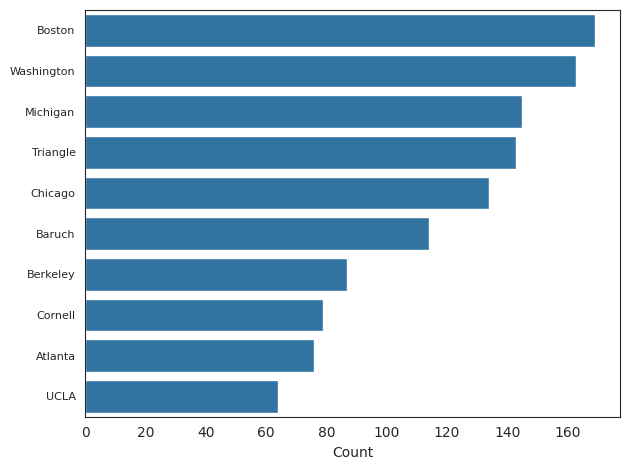

In [54]:
sns.set_style("white")

sns.barplot(data=graph1_1, y='ProjectRDC', x='Count')

plt.xlabel("Count")
plt.ylabel("")
plt.title("")
plt.yticks(fontsize=8)

plt.tight_layout()

plt.show()

In [55]:
# program started in 1989 so dropping before those years
graph1_2 = df_subset[df_subset["OutputYear"] > 1988]
graph1_2 =  graph1_2.groupby(["OutputYear"]).size().reset_index(name="Count")

In [56]:
graph1_2.head(n=2)

,OutputYear,Count
0,1989,6
1,1990,1


In [57]:
graph1_2

,OutputYear,Count
0,1989,6
1,1990,1
2,1991,2
3,1992,2
4,1993,6
5,1994,2
6,1995,3
7,1996,9
8,1997,14
9,1998,7


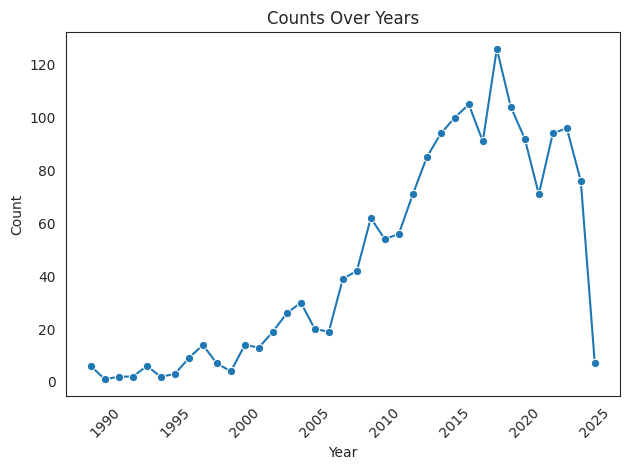

In [58]:
sns.set_style("white")
sns.lineplot(data=graph1_2, x='OutputYear', y='Count', marker='o')

# Add titles and labels
plt.title('Counts Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [59]:
df_subset.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputType,OutputStatus,...,OutputPages,PublicationDate,cited_by_count,OutputVenue,OutputMonth,OutputBiblio,authors,OutputType_Clean,PublicationDate_clean,OutputYear
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,article,published,...,484-521,2019-06-10,1,Industrial Relations A Journal of Economy and ...,6,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",Abigail M. Cooke; Thomas Kemeny; David L. Rigby,Journal Article Publication,2019-06-10,2019
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,preprint,published,...,NaN,2017-01-11,5,NaN,1,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",Adela Luque; Renuka Bhaskar; Sonya Rastogi; Ja...,Journal Article Publication,2017-01-11,2017


In [60]:
df_subset = df_subset[df_subset["OutputYear"] > 1988]

In [61]:
graph1_3 = df_subset['authors'].str.split(';', expand=True)

In [62]:
# Melt based on index
graph1_3 = graph1_3.reset_index()
# bring index into a column
df_long = graph1_3.melt(id_vars='index', var_name='variable', value_name='value')
df_long = df_long.set_index('index')


In [63]:
df_long.head(n=2)

,variable,value
index,,
0,0,Abigail M. Cooke
1,0,Adela Luque


In [64]:
df_long = df_long.dropna(subset=["value"])

In [65]:
df_long["value"] = df_long["value"].str.lower()

<ipython-input-65-9ad963b0cc12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["value"] = df_long["value"].str.lower()


In [66]:
df_long.head(n=2)

,variable,value
index,,
0,0,abigail m. cooke
1,0,adela luque


In [67]:
df_long= df_long.groupby("value").size().reset_index(name="Count").sort_values(by="Count", ascending=False)

In [68]:
df_long.head(n=2)

,value,Count
2158,scott h. holan,40
1138,john haltiwanger,29


In [69]:
df_long_10 = df_long.head(n=10)

In [70]:
df_long_10

,value,Count
2158,scott h. holan,40
1138,john haltiwanger,29
1088,jerome p. reiter,28
1043,javier miranda,27
1448,lucia foster,24
468,christopher k. wikle,24
1778,nathan goldschlag,21
2062,ron s. jarmin,19
2487,william r. kerr,18
1160,john v. winters,15


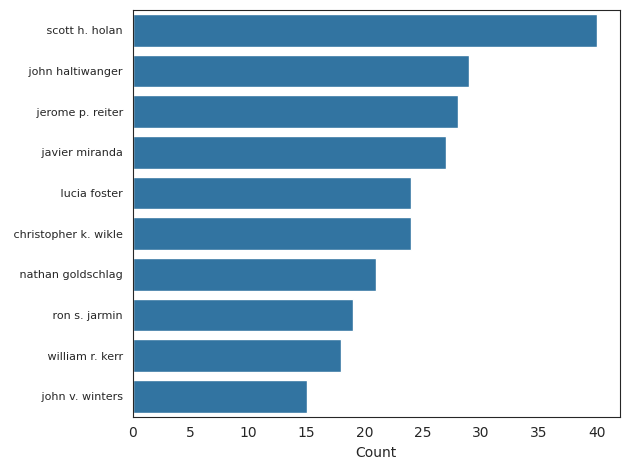

In [71]:
sns.set_style("white")

sns.barplot(data=df_long_10, y='value', x='Count')

plt.xlabel("Count")
plt.ylabel("")
plt.title("")
plt.yticks(fontsize=8)

plt.tight_layout()

plt.show()

In [72]:
# Melt based on index
graph1_3 = graph1_3.reset_index()
# bring index into a column
df_long = graph1_3.melt(id_vars='index', var_name='variable', value_name='value')
#df_long = df_long.set_index('index')

In [73]:
df_long = df_long.dropna(subset=["value"])

In [74]:
df_long = df_long.loc[:,["index", "value"]]

In [75]:
graph1_3 =  pd.concat([graph1_3, df_subset["cited_by_count"]], axis=1)

In [76]:
graph1_3= graph1_3.loc[:, ["index","cited_by_count"]]

In [77]:
df_long_cites = pd.merge(df_long, graph1_3, on="index", how='left', indicator=True)

In [78]:
h_index_per_author = df_long_cites.groupby('value')['cited_by_count'].apply(calculate_h_index)
df_long_cites['h_index'] = df_long_cites['value'].map(h_index_per_author)

In [79]:
h_index_per_author.sort_values(ascending=False, inplace=True)

In [80]:
df_long_cites_10 =h_index_per_author.head(n=10)

In [81]:
df_long_cites_10

,cited_by_count
value,
Javier Miranda,14
William R. Kerr,13
John Haltiwanger,13
Lucia Foster,12
Scott H. Holan,12
Nikolas Zolas,11
Jerome P. Reiter,11
Sari Pekkala Kerr,10
Andrew B. Bernard,9


In [82]:
df_long_cites_10 = df_long_cites_10.reset_index()
df_long_cites_10["value"] = df_long_cites_10["value"].str.lower()

## Plot by H-Index- Higher index more impactful

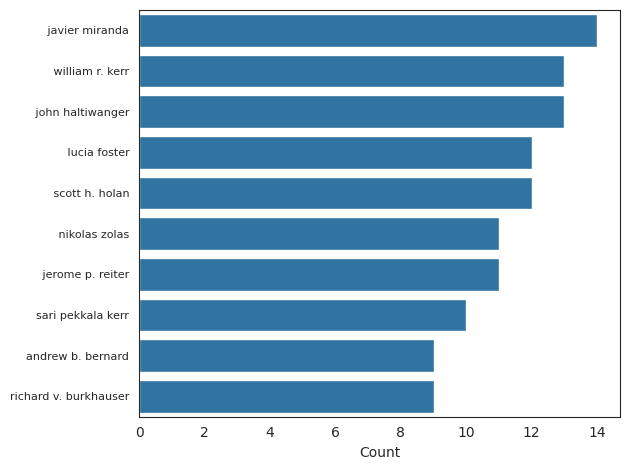

In [83]:
sns.set_style("white")

sns.barplot(data=df_long_cites_10, y='value', x='cited_by_count')

plt.xlabel("Count")
plt.ylabel("")
plt.title("")
plt.yticks(fontsize=8)

plt.tight_layout()

plt.show()

In [84]:
df_subset['PublicationDate'] = pd.to_datetime(df_subset['PublicationDate'])
# Specify reference date
reference_date = pd.Timestamp('2025-05-06')
# Calculate days since publication
df_subset['days_since_publication'] = (reference_date - df_subset['PublicationDate']).dt.days


In [85]:
df_subset.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputType,OutputStatus,...,PublicationDate,cited_by_count,OutputVenue,OutputMonth,OutputBiblio,authors,OutputType_Clean,PublicationDate_clean,OutputYear,days_since_publication
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,article,published,...,2019-06-10,1,Industrial Relations A Journal of Economy and ...,6,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",Abigail M. Cooke; Thomas Kemeny; David L. Rigby,Journal Article Publication,2019-06-10,2019,2157
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,preprint,published,...,2017-01-11,5,NaN,1,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",Adela Luque; Renuka Bhaskar; Sonya Rastogi; Ja...,Journal Article Publication,2017-01-11,2017,3037


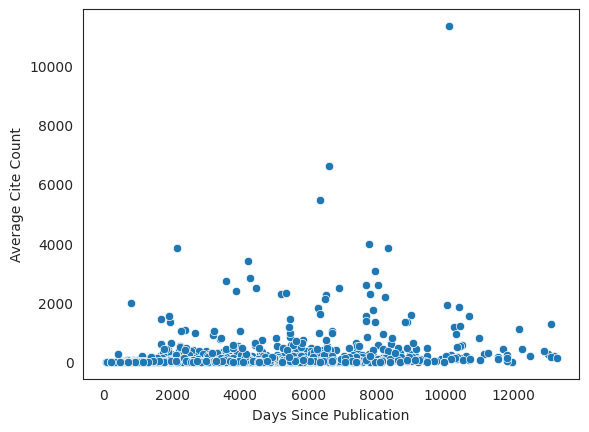

In [86]:
# Create a scatter plot using Seaborn
sns.scatterplot(x='days_since_publication', y='cited_by_count', data=df_subset)

# Add title
plt.title('')
plt.xlabel('Days Since Publication')
plt.ylabel('Average Cite Count')

# Show the plot
plt.show()

In [87]:
graph4 = df_subset.groupby("ProjectRDC")["cited_by_count"].agg("mean").sort_values(ascending=False).head(n=10)


In [88]:
graph4

,cited_by_count
ProjectRDC,
Penn State,597.033333
Yale,409.272727
Kansas City,265.000000
Berkeley,252.563218
Boston,182.887574
Utah,168.000000
Baruch,161.649123
Chicago,154.485075
Kentucky,151.933333


In [89]:
graph4 = graph4.reset_index()


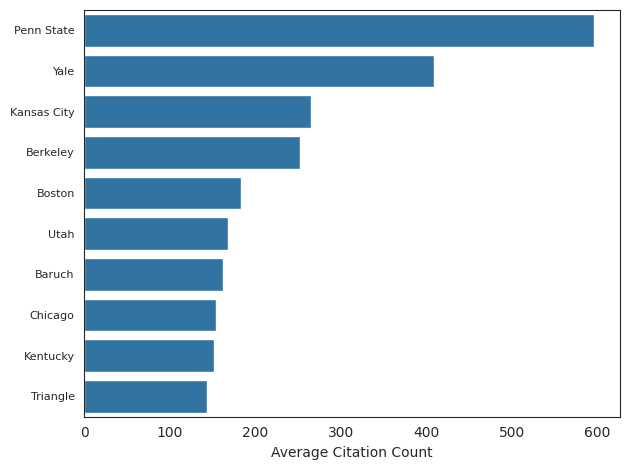

In [90]:
sns.set_style("white")

sns.barplot(data=graph4, y='ProjectRDC', x='cited_by_count')

plt.xlabel("Average Citation Count")
plt.ylabel("")
plt.title("")
plt.yticks(fontsize=8)

plt.tight_layout()

plt.show()

In [91]:
df_subset.groupby("OutputType_Clean")["cited_by_count"].agg("mean").sort_values(ascending=False).head(n=10)


,cited_by_count
OutputType_Clean,
Other Publication,340.636364
Journal Article Publication,140.517493
Book,127.046512
Working Paper,70.984211
Dataset,58.666667
Graduate Research Output,0.500000


In [92]:
graph1_6 = df_subset.groupby(["OutputType_Clean", "days_since_publication"]).agg({'cited_by_count': 'mean'}).reset_index()


In [93]:
graph1_6.sort_values(by="cited_by_count", ascending=False, inplace=True)

In [94]:
graph1_6

,OutputType_Clean,days_since_publication,cited_by_count
869,Journal Article Publication,10126,11324.0
768,Journal Article Publication,6339,5461.0
311,Journal Article Publication,2156,3853.0
839,Journal Article Publication,8318,3842.0
616,Journal Article Publication,4235,3393.0
...,...,...,...
45,Graduate Research Output,1374,0.0
47,Graduate Research Output,3292,0.0
46,Graduate Research Output,2317,0.0
8,Book,2090,0.0


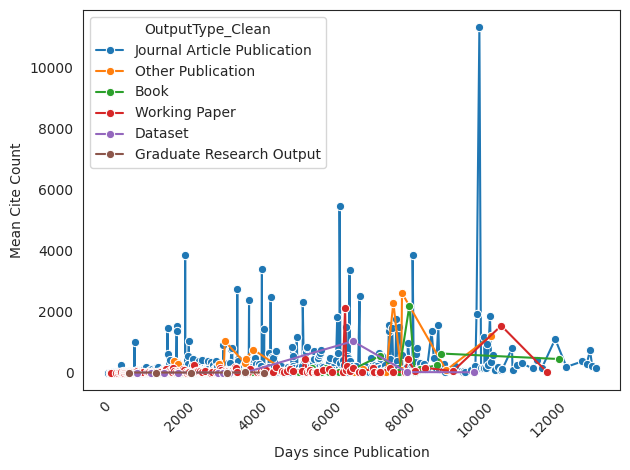

In [95]:
sns.set_style("white")
sns.lineplot(data=graph1_6, x='days_since_publication', y='cited_by_count', hue='OutputType_Clean', marker='o')

# Add titles and labels
plt.title('')
plt.xlabel('Days since Publication')
plt.ylabel('Mean Cite Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Section 2: Analysis

In [93]:
# checking structure of all datasets
column_names_list = df_subset.columns.to_list()
print(column_names_list)

['ProjectID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC', 'ProjectStartYear', 'ProjectEndYear', 'ProjectPI', 'OutputTitle', 'OutputType', 'OutputStatus', 'year', 'OutputVolume', 'OutputNumber', 'OutputPages', 'PublicationDate', 'cited_by_count', 'OutputVenue', 'OutputMonth', 'OutputBiblio', 'authors', 'OutputType_Clean', 'PublicationDate_clean', 'OutputYear', 'days_since_publication']


In [94]:
# checking structure of all datasets
column_names_list = data_24.columns.to_list()
print(column_names_list)

['ProjectID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC', 'ProjectStartYear', 'ProjectEndYear', 'ProjectPI', 'OutputTitle', 'OutputBiblio', 'OutputType', 'OutputStatus', 'OutputVenue', 'OutputYear', 'OutputMonth', 'OutputVolume', 'OutputNumber', 'OutputPages', 'OutputType_Clean']


In [95]:
# keeping only names found in 2024 dataset
df_subset_analysis = df_subset.loc[:,['ProjectID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC', 'ProjectStartYear',
 'ProjectEndYear', 'ProjectPI', 'OutputTitle', 'OutputBiblio', 'OutputType', 'OutputStatus', 'OutputVenue', 'OutputYear', 'OutputMonth', 'OutputVolume', 'OutputNumber', 'OutputPages', 'OutputType_Clean']]



In [96]:
data_24["Data Source"] = "FSRDC-verified 2024"

In [97]:
data_24.shape

(1734, 19)

In [98]:
df_subset.shape

(1662, 24)

In [99]:
df_subset_analysis["Data Source"] = "New"

In [100]:
# Joining datasets
df_subset_analysis= pd.concat([df_subset_analysis, data_24], ignore_index=True)

In [101]:
df_subset_analysis["Data Source"].value_counts()

,count
Data Source,
FSRDC-verified 2024,1734
New,1662


In [102]:
df_subset_analysis.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,OutputStatus,OutputVenue,OutputYear,OutputMonth,OutputVolume,OutputNumber,OutputPages,OutputType_Clean,Data Source
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",article,published,Industrial Relations A Journal of Economy and ...,2019,6,58.0,3,484-521,Journal Article Publication,New
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",preprint,published,NaN,2017,1,NaN,NaN,NaN,Journal Article Publication,New


In [103]:
df_subset_analysis.shape

(3396, 19)

In [104]:
df_subset_analysis["OutputType_Clean"].value_counts()

,count
OutputType_Clean,
Journal Article Publication,1867
Working Paper,907
Other Publication,417
Graduate Research Output,103
Book,74
Dataset,19
Software,4


### Classification of Output Type

Classifiying Journal Article Publication research output based on:


1.   Time since start of project and publication date
2.   Length of output title-



In [105]:
df_subset_analysis["TitleLen"] = df_subset_analysis["OutputTitle"].str.len()

In [106]:
df_subset_analysis['JournalArticle'] = np.where(df_subset_analysis['OutputType_Clean'] == "Journal Article Publication", 1, 0)


In [107]:
df_subset_analysis.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,...,OutputVenue,OutputYear,OutputMonth,OutputVolume,OutputNumber,OutputPages,OutputType_Clean,Data Source,TitleLen,JournalArticle
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",article,...,Industrial Relations A Journal of Economy and ...,2019,6,58.0,3,484-521,Journal Article Publication,New,58.0,1
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",preprint,...,NaN,2017,1,NaN,NaN,NaN,Journal Article Publication,New,100.0,1


In [108]:
# Calculate days since publication
df_subset_analysis['YearsSinceStart'] = (df_subset_analysis['OutputYear']-df_subset_analysis['ProjectStartYear'])


In [109]:
df_subset_analysis.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,...,OutputYear,OutputMonth,OutputVolume,OutputNumber,OutputPages,OutputType_Clean,Data Source,TitleLen,JournalArticle,YearsSinceStart
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",article,...,2019,6,58.0,3,484-521,Journal Article Publication,New,58.0,1,4.0
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",preprint,...,2017,1,NaN,NaN,NaN,Journal Article Publication,New,100.0,1,9.0


In [110]:
df_subset_analysis["ProjectRDC"].value_counts()


,count
ProjectRDC,
Boston,519
Chicago,335
Michigan,329
Triangle,277
Baruch,271
Washington,241
Berkeley,139
UCLA,138
Atlanta,133


In [111]:
dummies = pd.get_dummies(df_subset_analysis["ProjectRDC"], prefix="RDC")
df_subset_analysis = pd.concat([df_subset_analysis, dummies], axis=1)

In [112]:
df_subset_analysis.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,...,RDC_Stanford,RDC_Texas,RDC_Triangle,RDC_UCLA,RDC_UIUC,RDC_USC,RDC_Utah,RDC_Washington,RDC_Wisconsin,RDC_Yale
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",article,...,False,False,False,False,False,False,False,False,False,False
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",preprint,...,False,False,False,False,False,False,False,True,False,False


In [113]:
df_subset_analysis[df_subset_analysis["YearsSinceStart"] < 0].shape

(674, 57)

In [114]:
missing =df_subset_analysis[df_subset_analysis["YearsSinceStart"] < 0]

missing["Data Source"].value_counts()

,count
Data Source,
New,644
FSRDC-verified 2024,30


In [115]:
674-644

30

In [116]:
df_subset_analysis[df_subset_analysis["TitleLen"].isna()]


,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,...,RDC_Stanford,RDC_Texas,RDC_Triangle,RDC_UCLA,RDC_UIUC,RDC_USC,RDC_Utah,RDC_Washington,RDC_Wisconsin,RDC_Yale
3265,2229.0,Active,"The Impact of Trade on Consumption, Earnings, ...",Utah,2022.0,NaN,Jiashuo Feng,NaN,"Borusyak, Kirill and Xavier Jaravel. Are Trade...",JA,...,False,False,False,False,False,False,True,False,False,False


In [117]:
df_subset_analysis["TitleLen"] = df_subset_analysis["TitleLen"].fillna(df_subset_analysis["ProjectTitle"].str.len())


In [118]:
df_subset_analysis_logisticreg = df_subset_analysis[df_subset_analysis["YearsSinceStart"] >= 0]

In [119]:
X_feature = df_subset_analysis_logisticreg[["YearsSinceStart", "TitleLen",
                                "RDC_Boston", "RDC_Chicago", "RDC_Michigan", "RDC_Triangle", "RDC_Baruch", "RDC_Washington",
    "RDC_Berkeley", "RDC_UCLA", "RDC_Atlanta", "RDC_Texas", "RDC_Cornell", "RDC_Minnesota",
    "RDC_Fed Board", "RDC_Penn State", "RDC_Colorado", "RDC_Stanford", "RDC_Missouri",
    "RDC_Utah", "RDC_Wisconsin", "RDC_Philadelphia", "RDC_USC", "RDC_Georgetown",
    "RDC_Irvine", "RDC_Maryland", "RDC_Yale", "RDC_Kentucky", "RDC_Austin", "RDC_Dallas",
    "RDC_Nebraska", "RDC_Seattle", "RDC_Kansas City", "RDC_CMU", "RDC_UIUC",
    "RDC_NCRN"]]
Y = df_subset_analysis_logisticreg["JournalArticle"]

l_model = lm.LogisticRegression()
l_model.fit(X_feature, Y)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [120]:
df_subset_analysis_logisticreg["Predicted Class"] = l_model.predict(X_feature)
df_subset_analysis_logisticreg.head(n=2)

<ipython-input-120-357456e325ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_analysis_logisticreg["Predicted Class"] = l_model.predict(X_feature)


,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,...,RDC_Texas,RDC_Triangle,RDC_UCLA,RDC_UIUC,RDC_USC,RDC_Utah,RDC_Washington,RDC_Wisconsin,RDC_Yale,Predicted Class
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",article,...,False,False,False,False,False,False,False,False,False,0
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",preprint,...,False,False,False,False,False,False,True,False,False,1


In [121]:
l_model.score(X_feature, Y)

0.6737692872887583

In [122]:
from sklearn.metrics import confusion_matrix

# Be careful – confusion_matrix takes in y_true as the first parameter and y_pred as the second.
# Don't mix these up!
cm = confusion_matrix(Y, l_model.predict(X_feature))
cm

array([[1068,  325],
       [ 563,  766]])

In [123]:
Y_hat = l_model.predict(X_feature)
tp = np.sum((Y_hat == 1) & (Y == 1))
tn = np.sum((Y_hat == 0) & (Y == 0))

fp = np.sum((Y_hat == 1) & (Y == 0))
fn = np.sum((Y_hat == 0) & (Y == 1))


print("True Positives: ", tp)
print("True Negatives: ", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives:  766
True Negatives:  1068
False Positives: 325
False Negatives: 563


In [124]:
precision = tp / (tp + fp)
precision

np.float64(0.7021081576535289)

In [125]:
recall = tp / (tp + fn)
recall

np.float64(0.5763732129420617)

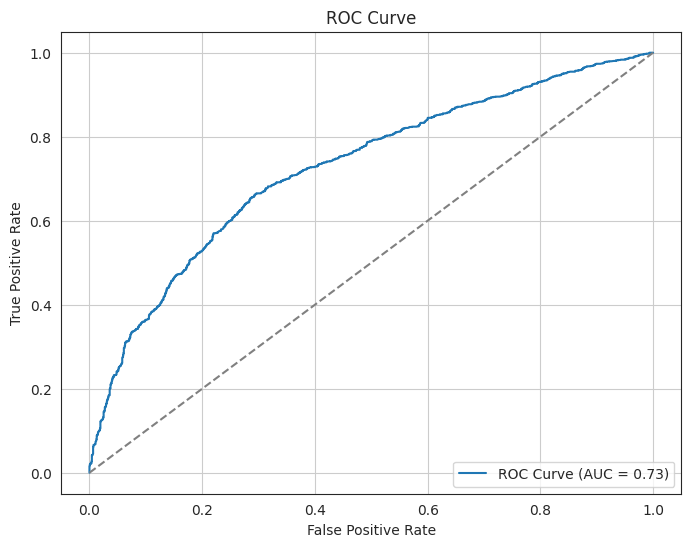

In [126]:
from sklearn.metrics import roc_curve, roc_auc_score

# Step 2: Get predicted probabilities for the positive class (class = 1)
y_probs = l_model.predict_proba(X_feature)[:, 1]

# Step 3: Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y, y_probs)

# Step 4: Compute AUC
roc_auc = roc_auc_score(Y, y_probs)

# Step 5: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [127]:
df_subset_analysis_logisticreg["JournalArticle"].value_counts()

,count
JournalArticle,
0,1393
1,1329


In [128]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# y_true: your true binary labels (0 or 1)
# y_scores: predicted probabilities (not hard classifications)

precision, recall, thresholds = precision_recall_curve(Y, y_probs)

# Calculate F1 scores at each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # small epsilon to avoid division by zero

# Find the threshold that gives the max F1
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best threshold: {best_threshold:.2f}")
print(f"Max F1 Score: {best_f1:.3f}")

Best threshold: 0.39
Max F1 Score: 0.684


In [129]:
threshold = 0.39
df_subset_analysis_logisticreg['predicted_prob'] = l_model.predict_proba(X_feature)[:, 1]
# Create a new column 'predicted_label' using the threshold
df_subset_analysis_logisticreg['predicted_label'] = (df_subset_analysis_logisticreg['predicted_prob'] >= threshold).astype(int)

<ipython-input-129-b13deb7b4811>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_analysis_logisticreg['predicted_prob'] = l_model.predict_proba(X_feature)[:, 1]
<ipython-input-129-b13deb7b4811>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_analysis_logisticreg['predicted_label'] = (df_subset_analysis_logisticreg['predicted_prob'] >= threshold).astype(int)


In [130]:
df_subset_analysis_logisticreg.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,...,RDC_UCLA,RDC_UIUC,RDC_USC,RDC_Utah,RDC_Washington,RDC_Wisconsin,RDC_Yale,Predicted Class,predicted_prob,predicted_label
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",article,...,False,False,False,False,False,False,False,0,0.336815,0
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",preprint,...,False,False,False,False,True,False,False,1,0.821906,1


In [131]:
Y_hat = df_subset_analysis_logisticreg['predicted_label']
tp = np.sum((Y_hat == 1) & (Y == 1))
tn = np.sum((Y_hat == 0) & (Y == 0))

fp = np.sum((Y_hat == 1) & (Y == 0))
fn = np.sum((Y_hat == 0) & (Y == 1))


print("True Positives: ", tp)
print("True Negatives: ", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives:  1054
True Negatives:  691
False Positives: 702
False Negatives: 275


In [132]:
precision = tp / (tp + fp)
precision

np.float64(0.6002277904328018)

In [133]:
recall = tp / (tp + fn)
recall

np.float64(0.7930775018811136)

In [134]:
df_subset_analysis_logisticreg.shape

(2722, 60)

## LLM Classification

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# Load the tokenizer and model
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
from tqdm import tqdm
# Function to classify text
def classify_text(text):
    prompt = f"Is the following text about labor market, producitvity and human capital? Answer yes or no.\n\n{text}"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = model.generate(**inputs, max_new_tokens=10)
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result.strip().lower()

In [ ]:
# Apply classification to the DataFrame
tqdm.pandas()  # for progress bar
df_subset_analysis["Economics_Labor"] = df_subset_analysis["OutputTitle"].progress_apply(classify_text)


100%|██████████| 3396/3396 [1:06:03<00:00,  1.17s/it]


In [ ]:
df_subset_analysis["Economics_Labor"].value_counts()

,count
Economics_Labor,
no,3359
yes,37


In [136]:
df_subset_analysis.to_csv('output_classification.csv', index=False)

In [137]:
data2024_enriched =load_data('cleaned_abstracts_project3.csv')


In [138]:
df_subset_analysis = load_data('output_classification.csv')

In [139]:
df_subset_analysis.shape

(3396, 57)

## Cite Count Analysis

In [137]:
data2024_enriched.head(n=3)

NameError: name 'data2024_enriched' is not defined

In [141]:
data2024_enriched.columns.tolist()

['ProjectTitle',
 'Project Abstract',
 'OutputTitle',
 'OutputBiblio',
 'OutputYear',
 'ProjectRDC',
 'Keywords',
 'Authors',
 'Year',
 'DOI',
 'abstracts',
 'concepts_openalex',
 'cited_by_count',
 'keywords_openalex']

In [142]:
data2024_enriched = data2024_enriched.loc[:, ['ProjectTitle',
 'OutputTitle',
 'OutputBiblio',
 'OutputYear',
 'ProjectRDC',"cited_by_count"]]

In [143]:
df_new_cites = df_subset.loc[:,['ProjectID', 'ProjectTitle', 'ProjectRDC','ProjectPI', 'OutputTitle', 'OutputYear', 'OutputBiblio', 'cited_by_count']]

In [144]:
df_subset_analysis_new = df_subset_analysis[df_subset_analysis["Data Source"] == "New"]

In [145]:
df_subset_analysis_old = df_subset_analysis[df_subset_analysis["Data Source"] != "New"]

In [ ]:
data_24_merged = pd.merge(df_subset_analysis_old, data2024_enriched, on=['ProjectTitle',
 'OutputTitle',
 'OutputBiblio',
 'OutputYear',
 'ProjectRDC'],how='left',indicator=True)

In [ ]:
data_24_merged.shape

(1734, 60)

In [ ]:
df_subset_analysis_old.shape

(1734, 58)

In [ ]:
data2024_enriched.shape

(1735, 6)

In [ ]:
data_new_merged = pd.merge(df_subset_analysis_new, df_new_cites, on=['ProjectID', 'ProjectTitle', 'ProjectRDC','ProjectPI', 'OutputTitle', 'OutputYear', 'OutputBiblio'],how='left')

In [ ]:
df_subset_analysis_new.shape

(1662, 58)

In [ ]:
df_subset_analysis_total = pd.concat([data_new_merged, data_24_merged], ignore_index=True)

In [ ]:
df_subset_analysis_total.shape

(3396, 60)

In [ ]:
df_subset_analysis_total.head(n=2)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,...,RDC_UCLA,RDC_UIUC,RDC_USC,RDC_Utah,RDC_Washington,RDC_Wisconsin,RDC_Yale,Economics_Labor,cited_by_count,_merge
0,1410.0,Completed,The Effects of Adjustment Costs on Market Comp...,Chicago,2015.0,2018.0,German Bet,Vulnerable Jobs and the Wage Effects of Import...,"Cooke, Abigail M.; Kemeny, Thomas; Rigby, Davi...",article,...,False,False,False,False,False,False,False,no,1,NaN
1,685.0,Completed,The Effect of Health Care Costs on the Growth ...,Washington,2008.0,2010.0,Adela Luque,Coverage and Agreement of Administrative Recor...,"Luque, Adela; Bhaskar, Renuka; Rastogi, Sonya;...",preprint,...,False,False,False,False,True,False,False,no,5,NaN


In [ ]:
df_subset_analysis_total['Economics_Labor_dummy'] = np.where(df_subset_analysis_total['Economics_Labor'] == "yes", 1, 0)


In [136]:
# List of target RDCs
target_rdcs = ["Boston", "Washington", "Michigan", "Triangle", "Chicago",
               "Baruch", "Berkley", "Cornell", "Atlanta", "UCLA"]

# Create the 'top10' column based on the condition
df_subset_analysis_total['top10'] = np.where(df_subset_analysis_total['ProjectRDC'].isin(target_rdcs), 1, 0)

NameError: name 'df_subset_analysis_total' is not defined

In [ ]:
df_subset_analysis_total.loc[:, df_subset_analysis_total.select_dtypes(include=['number']).columns] = df_subset_analysis_total.select_dtypes(include=['number']).fillna(0)


In [ ]:
# List of columns to convert
columns_to_convert = ['cited_by_count', 'top10', 'YearsSinceStart', 'TitleLen', 'JournalArticle', 'Economics_Labor_dummy']

# Apply pd.to_numeric() to each specified column
df_subset_analysis_total[columns_to_convert] = df_subset_analysis_total[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
df_subset_analysis_total["YearSincePublication"] = 2025 - df_subset_analysis_total["OutputYear"]

In [ ]:
# List of columns to replace NaN with 0
columns_to_fill = ['cited_by_count', 'top10', 'YearsSinceStart', 'TitleLen', 'JournalArticle', 'Economics_Labor_dummy']

# Replace NaN with 0 in specified columns
df_subset_analysis_total[columns_to_fill] = df_subset_analysis_total[columns_to_fill].fillna(0)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# List of numeric columns
numeric_cols = ['JournalArticle', 'YearsSinceStart', 'TitleLen']

# Select the numeric data
X = df_subset_analysis_total[numeric_cols]
X.fillna(0, inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_scaled)

<ipython-input-610-531529fd411a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
df_pca

,PC1,PC2
0,0.204263,-0.055181
1,1.136933,0.859319
2,-0.172083,0.557837
3,0.658696,-0.090460
4,0.667839,-0.508171
...,...,...
3391,0.207888,0.259375
3392,-1.772110,-0.476519
3393,-0.872388,-0.129364
3394,-0.556418,-0.056593


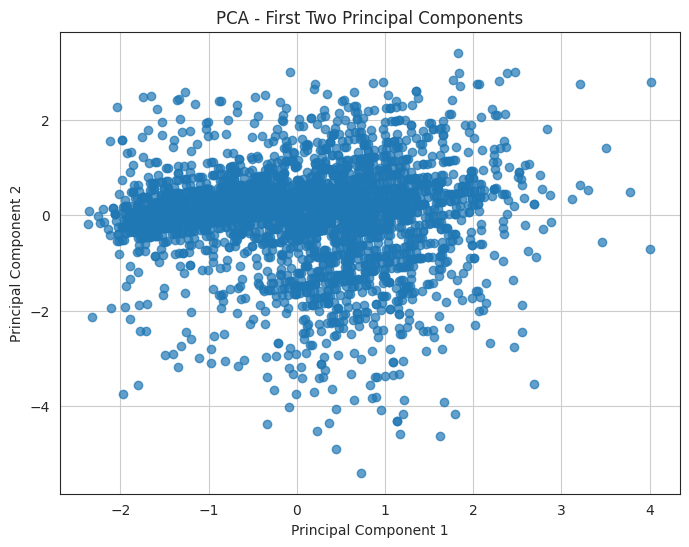

In [ ]:
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.7)
plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
df_subset_analysis_total = pd.concat([df_subset_analysis_total, df_pca], axis=1)


In [ ]:
df_subset_analysis_total["cited_by_count"].mean()

np.float64(420.06095406360424)

In [ ]:
df_subset_analysis_total['highcite'] = np.where(df_subset_analysis_total['cited_by_count'] > 420, "High", "Low")

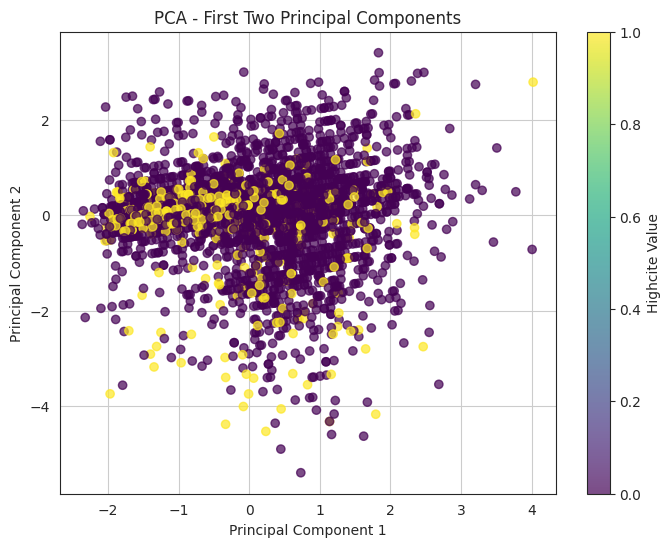

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'df_subset_analysis_total' contains the PCA components and 'highcite' column
# Map 'Low' to 0 and 'High' to 1
df_subset_analysis_total['highcite_numeric'] = df_subset_analysis_total['highcite'].map({'Low': 0, 'High': 1})

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_subset_analysis_total['PC1'],
    df_subset_analysis_total['PC2'],
    c=df_subset_analysis_total['highcite_numeric'],
    cmap='viridis',  # You can choose other colormaps like 'plasma', 'inferno', etc.
    alpha=0.7
)

# Add a color bar to indicate the mapping of 'highcite' values to colors
plt.colorbar(scatter, label='Highcite Value')

plt.title('PCA - First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)


[0.39072679 0.33603221]


In [ ]:
print(np.cumsum(pca.explained_variance_ratio_))


[0.39072679 0.726759  ]


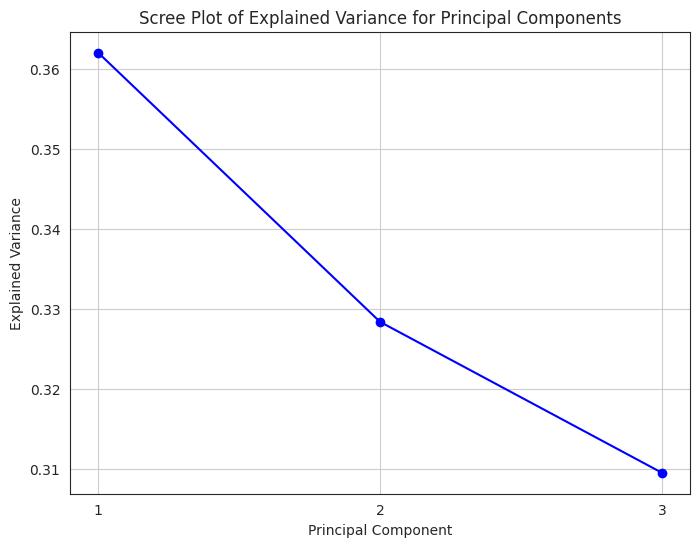

In [ ]:

# Assuming df_subset_analysis_total is your DataFrame and numeric_cols are the numeric columns
numeric_cols = ['cited_by_count', 'YearsSinceStart', 'TitleLen']
X = df_subset_analysis_total[numeric_cols].fillna(0)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.title('Scree Plot of Explained Variance for Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()


In [ ]:
import statsmodels.formula.api as smf # for multiple regression

In [ ]:
df_subset_analysis_total.shape

(3396, 67)

In [ ]:
df_subset_analysis_total['cited_by_count'].describe()

,cited_by_count
count,3396.000000
mean,420.060954
std,2190.785230
min,0.000000
25%,3.000000
50%,21.000000
75%,104.000000
max,35633.000000


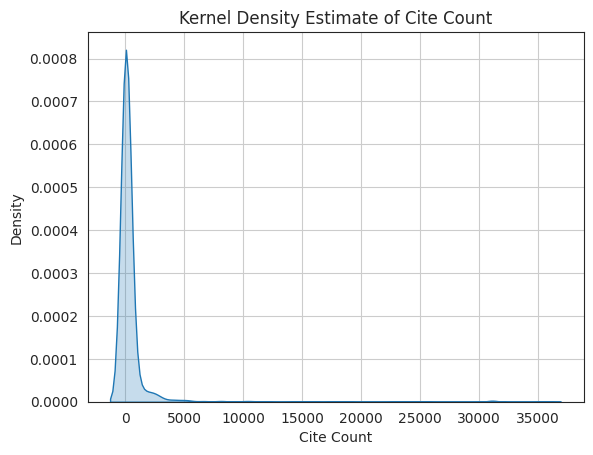

In [ ]:
sns.kdeplot(data=df_subset_analysis_total, x='cited_by_count', fill=True, bw_adjust=1)

plt.title('Kernel Density Estimate of Cite Count')
plt.xlabel('Cite Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
df_subset_analysis_total['cited_by_count_log'] = np.log(df_subset_analysis_total['cited_by_count'] + 1)


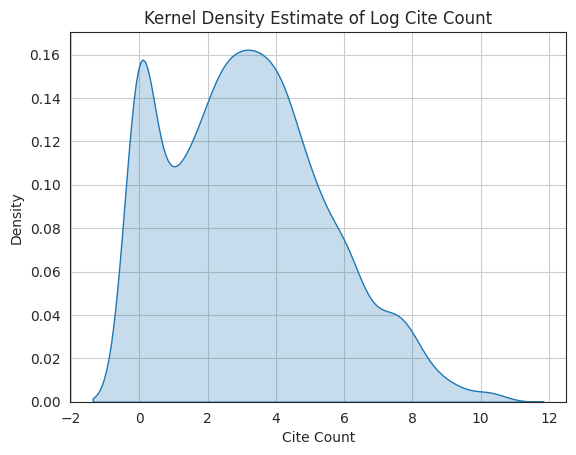

In [ ]:
sns.kdeplot(data=df_subset_analysis_total, x='cited_by_count_log', fill=True, bw_adjust=1)

plt.title('Kernel Density Estimate of Log Cite Count')
plt.xlabel('Cite Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
model_ols = smf.ols('cited_by_count_log ~ top10+YearSincePublication+TitleLen+JournalArticle*Economics_Labor_dummy', data=df_subset_analysis_total).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:     cited_by_count_log   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     33.61
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.36e-39
Time:                        01:37:25   Log-Likelihood:                -7570.2
No. Observations:                3396   AIC:                         1.515e+04
Df Residuals:                    3389   BIC:                         1.520e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [ ]:
df_subset_analysis_total["Economics_Labor_dummy"].value_counts()

,count
Economics_Labor_dummy,
0,3359
1,37


In [ ]:
37/3359

0.011015183090205419

# Extended Analysis

## Data Preparation

In [96]:
# Reopen enriched data
try:
  with open("cleaned_abstracts_project3.csv", "r") as f:
    df_2024_enriched = pd.read_csv(f)
except FileNotFoundError:
    print("cleaned_abstracts_project3.csv not found")

df_2024_enriched.head()

,ProjectTitle,Project Abstract,OutputTitle,OutputBiblio,OutputYear,ProjectRDC,Keywords,Authors,Year,DOI,abstracts,concepts_openalex,cited_by_count,keywords_openalex
0,The Impact of Foreign Trade on the U.S. Economy,The project will proceed in three phases. The ...,"Entry, Expansion, and Intensity in the U.S. Ex...","Bernard, A.B. and Jensen, J.B. (2004), Entry, ...",2004.0,Boston,NaN,"Bernard, A.B. and Jensen, J.B.",2004.0,10.1111/j.1467-9396.2004.00473.x,Abstract US exports grew at 10.3% per year fro...,"Boom, Economics, Productivity, Sunk costs, Int...",164,Global trade and economics; Economic Growth an...
1,The Impact of Foreign Trade on the U.S. Economy,The project will proceed in three phases. The ...,Product Choice and Product Switching,"Bernard, Andrew B., Stephen Redding and Peter ...",2003.0,Boston,NaN,"Bernard, Andrew B., Stephen Redding and Peter ...",2003.0,NaN,This paper develops a model of endogenous prod...,"Product (mathematics), Business, Mathematics, ...",27,Firm Innovation and Growth; Digital Platforms ...
2,The Impact of Foreign Trade on the U.S. Economy,The project will proceed in three phases. The ...,Plants and Productivity in International Trade,"Bernard, Andrew, B., Jonathan Eaton, J. Bradfo...",2003.0,Boston,NaN,"Bernard, Andrew, B., Jonathan Eaton, J. Bradfo...",2003.0,10.1257/000282803769206296,We reconcile trade theory with plant-level exp...,"Productivity, Economics, Imperfect competition...",3054,Global trade and economics; Global Trade and C...
3,The Impact of Foreign Trade on the U.S. Economy,The project will proceed in three phases. The ...,Why Some Firms Export,"Bernard, Andrew B., J. Bradford Jensen. Review...",2004.0,Boston,NaN,"Bernard, Andrew B., J. Bradford Jensen. Review...",2004.0,10.1162/003465304323031111,This paper examines the factors that increase ...,"Promotion (chess), Business, Panel data, Inter...",1549,Global trade and economics; Economic Growth an...
4,The Impact of Foreign Trade on the U.S. Economy,The project will proceed in three phases. The ...,The Deaths of Manufacturing Plants,"Bernard, Andrew B. and J. Bradford Jensen. “Th...",2002.0,Boston,NaN,"Bernard, Andrew B. and J. Bradford Jensen. “Th...",9026.0,NaN,This paper examines the causes of manufacturin...,Business,121,Firm Innovation and Growth; Global trade and e...


In [97]:
df_2024_enriched.columns.tolist()

['ProjectTitle',
 'Project Abstract',
 'OutputTitle',
 'OutputBiblio',
 'OutputYear',
 'ProjectRDC',
 'Keywords',
 'Authors',
 'Year',
 'DOI',
 'abstracts',
 'concepts_openalex',
 'cited_by_count',
 'keywords_openalex']

In [98]:
# Rename Authors to authors and keywords_openalex to topics
df_2024_enriched = df_2024_enriched.rename(columns={'Authors': 'authors', 'keywords_openalex': 'topics', "abstracts": "abstract"})

In [99]:
df.columns.tolist()

['ProjID',
 'ProjectStatus',
 'ProjectTitle',
 'ProjectRDC',
 'ProjectYearStarted',
 'ProjectYearEnded',
 'ProjectPI',
 'OutputTitle',
 'OutputType',
 'OutputStatus',
 'OutputYear',
 'OutputVolume',
 'OutputNumber',
 'OutputPages',
 'doi',
 'title',
 'abstract',
 'year',
 'publication_date',
 'cited_by_count',
 'authors',
 'affiliations',
 'topics',
 'OutputVenue',
 'OutputMonth',
 'OutputBibliography',
 'matched_dataset_terms']

In [100]:
# Keep only meaningful columns
columns_to_keep = ["ProjectTitle","ProjectRDC","OutputTitle","OutputYear","authors","abstract","topics","cited_by_count"]
df_2024_enriched = df_2024_enriched.loc[:, columns_to_keep]
df_new_narrow = df.loc[:, columns_to_keep]

In [101]:
# merge original data and new data
df_extended = pd.concat([df_2024_enriched, df_new_narrow], ignore_index=True)

In [102]:
df_extended.head(5)

,ProjectTitle,ProjectRDC,OutputTitle,OutputYear,authors,abstract,topics,cited_by_count
0,The Impact of Foreign Trade on the U.S. Economy,Boston,"Entry, Expansion, and Intensity in the U.S. Ex...",2004.0,"Bernard, A.B. and Jensen, J.B.",Abstract US exports grew at 10.3% per year fro...,Global trade and economics; Economic Growth an...,164
1,The Impact of Foreign Trade on the U.S. Economy,Boston,Product Choice and Product Switching,2003.0,"Bernard, Andrew B., Stephen Redding and Peter ...",This paper develops a model of endogenous prod...,Firm Innovation and Growth; Digital Platforms ...,27
2,The Impact of Foreign Trade on the U.S. Economy,Boston,Plants and Productivity in International Trade,2003.0,"Bernard, Andrew, B., Jonathan Eaton, J. Bradfo...",We reconcile trade theory with plant-level exp...,Global trade and economics; Global Trade and C...,3054
3,The Impact of Foreign Trade on the U.S. Economy,Boston,Why Some Firms Export,2004.0,"Bernard, Andrew B., J. Bradford Jensen. Review...",This paper examines the factors that increase ...,Global trade and economics; Economic Growth an...,1549
4,The Impact of Foreign Trade on the U.S. Economy,Boston,The Deaths of Manufacturing Plants,2002.0,"Bernard, Andrew B. and J. Bradford Jensen. “Th...",This paper examines the causes of manufacturin...,Firm Innovation and Growth; Global trade and e...,121


## Projects by citations

In [103]:
# Identify projects with most citations
# Clean and aggregate
df_extended["cited_by_count"] = pd.to_numeric(df_extended["cited_by_count"], errors="coerce")
top_projects = (
    df_extended.groupby("ProjectTitle", as_index=False)["cited_by_count"]
    .sum()
    .sort_values(by="cited_by_count", ascending=False)
    .head(5)
)

# Truncate titles to 100 characters
top_projects["ProjectTitle"] = top_projects["ProjectTitle"].apply(
    lambda x: x if len(x) <= 50 else x[:49] + "..."
)

# Format citation counts: round and add commas
top_projects["cited_by_count"] = top_projects["cited_by_count"].round(0).astype(int).apply(lambda x: f"{x:,}")

# Rename columns for LaTeX
top_projects.columns = ["Project Title", "Total Citations"]

# Output LaTeX-formatted table
latex_table = top_projects.to_latex(index=False, escape=True, column_format="p{10cm}r")

print(latex_table)


\begin{tabular}{p{10cm}r}
\toprule
Project Title & Total Citations \\
\midrule
The Long-Run Determinants of Social, Demographic,... & 119,123 \\
Organizations in the Digital Economy: Information... & 84,724 \\
Firm Organization Across Space & 73,050 \\
Innovation and Market Concentration & 55,858 \\
Establishment Human Resource Practices & 50,390 \\
\bottomrule
\end{tabular}



## SVD of Topics

In [104]:
# Expand the semicolon-separated "topics" into a dummy matrix
topic_dummies = (
    df_extended["topics"]
    .fillna("")  # handle NaNs
    .str.split(";")  # split on semicolon
    .explode()  # make one row per topic
    .str.strip()  # remove leading/trailing whitespace
    .pipe(lambda s: pd.get_dummies(s))  # convert to one-hot
    .groupby(level=0)
    .sum()  # re-aggregate by original row
)

topic_dummies.head()

,,Academic Freedom and Politics,Academic and Historical Perspectives in Psychology,Accounting Theory and Financial Reporting,Accounting and Organizational Management,Action Observation and Synchronization,Acute Lymphoblastic Leukemia research,Adolescent Sexual and Reproductive Health,Adolescent and Pediatric Healthcare,Advanced Causal Inference Techniques,...,Wildlife Ecology and Conservation,Wine Industry and Tourism,Work-Family Balance Challenges,Working Capital and Financial Performance,Workplace Health and Well-being,World Trade Organization Law,Youth Development and Social Support,Youth Education and Societal Dynamics,demographic modeling and climate adaptation,scientometrics and bibliometrics research
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# Total number of elements in the matrix
total_elements = topic_dummies.size

# Number of non-zero (i.e., ones)
nonzero_elements = topic_dummies.values.sum()

# Sparsity = proportion of zero elements
sparsity = 1 - (nonzero_elements / total_elements)

print(f"Sparsity of topic_dummies: {sparsity:.4f} ({sparsity*100:.2f}%)")

Sparsity of topic_dummies: 0.9962 (99.62%)


In [106]:
print(nonzero_elements)

9442


In [141]:
# Run SVD since data is sparse
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10, random_state=42)
X_svd = svd.fit_transform(topic_dummies)
svd_df = pd.DataFrame(X_svd, columns=[f"SVD_{i+1}" for i in range(X_svd.shape[1])])

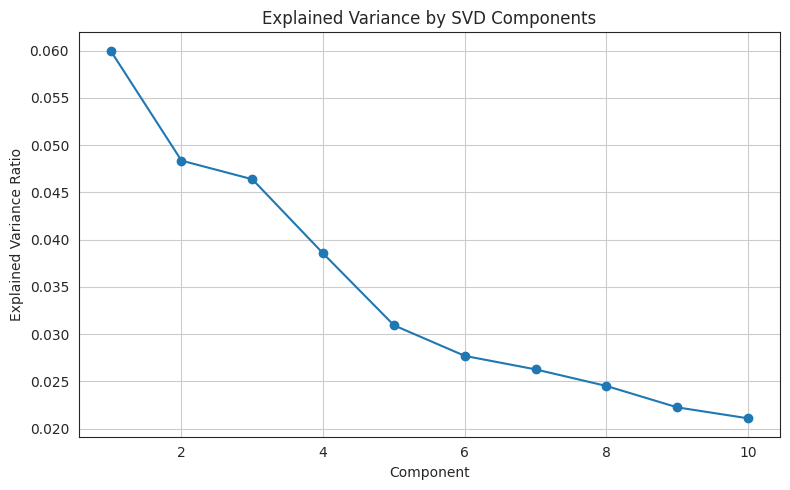

In [108]:
# Explained variance ratio from the SVD model
explained = svd.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title('Explained Variance by SVD Components')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

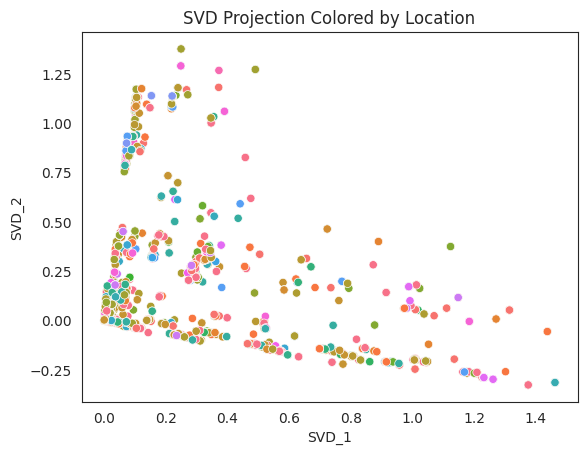

In [109]:
# Plot the first two components
svd_df["project"] = df_extended["ProjectRDC"].values  # or another category
sns.scatterplot(data=svd_df, x="SVD_1", y="SVD_2", hue="project", legend=False)
plt.title("SVD Projection Colored by Location")
plt.show()

## PCA of Topics

In [144]:
# Run PCA as an alternative
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(topic_dummies)

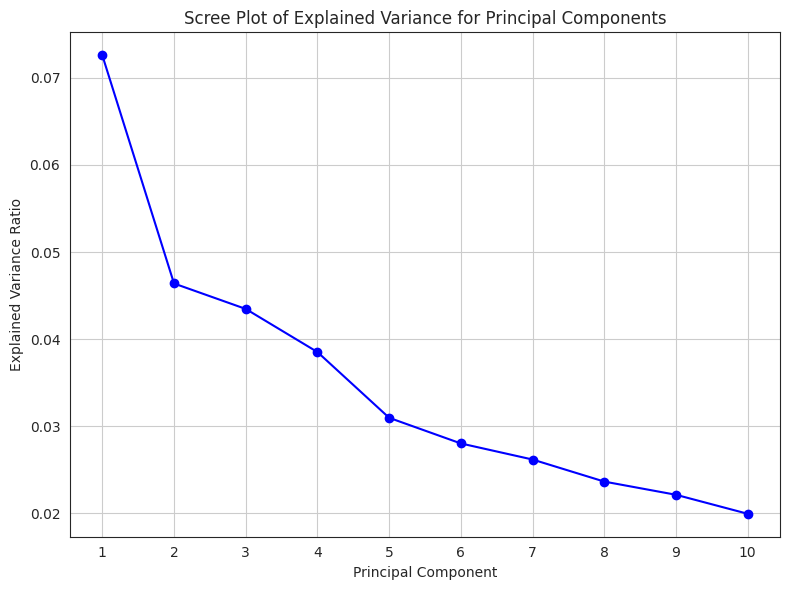

In [145]:
# Explained variance ratio from the PCA model
explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.title('Scree Plot of Explained Variance for Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

## BERTopic applied to keywords

In [110]:
# Replace NaNs with empty strings, clean spacing
documents = (
    df_extended["topics"]
    .fillna("")
    .apply(lambda x: " ".join([t.strip() for t in x.split(";") if t.strip()]))
    .tolist()
)

In [113]:
from bertopic import BERTopic

# Create the model — you can adjust the embedding model if needed
topic_model = BERTopic(top_n_words=10, nr_topics=10, verbose=True)

# Fit and transform the model
topics, probs = topic_model.fit_transform(documents)

# Assign topics to the dataframe
df_extended["BERTopic"] = topics

2025-05-08 18:24:44,869 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/107 [00:00<?, ?it/s]

2025-05-08 18:25:17,606 - BERTopic - Embedding - Completed ✓
2025-05-08 18:25:17,610 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-08 18:25:38,491 - BERTopic - Dimensionality - Completed ✓
2025-05-08 18:25:38,493 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-08 18:25:38,635 - BERTopic - Cluster - Completed ✓
2025-05-08 18:25:38,637 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-08 18:25:38,819 - BERTopic - Representation - Completed ✓
2025-05-08 18:25:38,820 - BERTopic - Topic reduction - Reducing number of topics
2025-05-08 18:25:38,837 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-08 18:25:38,940 - BERTopic - Representation - Completed ✓
2025-05-08 18:25:38,946 - BERTopic - Topic reduction - Reduced number of topics from 140 to 10


In [122]:
# Visualization
topic_model.visualize_topics()

In [123]:
# Show the top 10 words for each topic
topic_summaries = topic_model.get_topic_info()  # topic_model is your BERTopic object

# Optional: rename and display
topic_summaries = topic_summaries.rename(columns={"Name": "Top Words", "Topic": "BERTopic"})
print(topic_summaries[["BERTopic", "Top Words"]].head(10))

   BERTopic                                   Top Words
0        -1           -1_and_economics_economic_studies
1         0                0_and_urban_studies_analysis
2         1                1_and_innovation_growth_firm
3         2             2_health_care_healthcare_issues
4         3         3_data_estimation_population_census
5         4               4_no_keywords_found_available
6         5  5_education_organizational_higher_research
7         6                     6_light_on_marine_plant
8         7  7_crime_patterns_interventions_perceptions
9         8       8_community_development_social_cities


In [124]:
# Human Coded labels
topic_labels = {
    -1: "General Economics",
    0: "Urban Studies",
    1: "Firms",
    2: "Healthcare",
    3: "Data Estimation",
    4: "None",
    5: "Education",
    6: "Environment",
    7: "Crime",
    8: "Community Development"
}

# Map to your main dataframe
df_extended["BERTopicLabel"] = df_extended["BERTopic"].map(topic_labels)

In [152]:
# Latex Table
# Count number of documents per topic label
topic_counts = (
    df_extended["BERTopicLabel"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Topic Label", "BERTopicLabel": "Topic", "count" : "Number of Outputs"})
)

# Export to LaTeX
latex_table = topic_counts.to_latex(index=False, column_format="p{10cm}r")

print(latex_table)

\begin{tabular}{p{10cm}r}
\toprule
Topic & Number of Outputs \\
\midrule
Urban Studies & 1403 \\
Firms & 1104 \\
General Economics & 418 \\
Healthcare & 226 \\
Data Estimation & 125 \\
None & 42 \\
Education & 39 \\
Environment & 28 \\
Crime & 19 \\
Community Development & 11 \\
\bottomrule
\end{tabular}



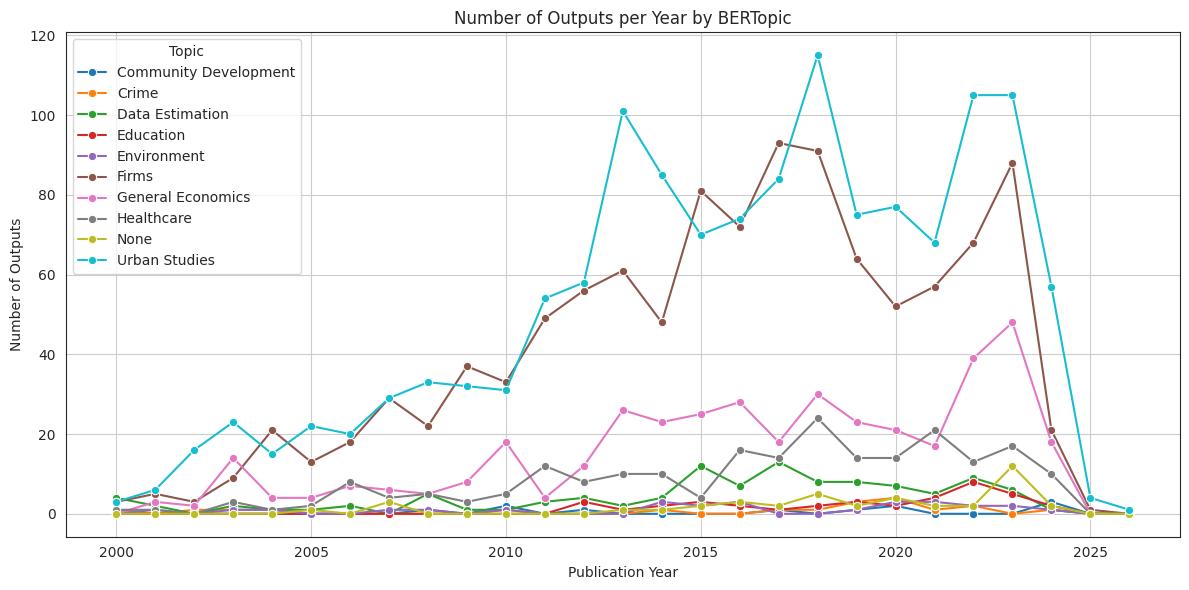

In [153]:
# Clean and filter
df_plot = df_extended.copy()
df_plot["OutputYear"] = pd.to_numeric(df_plot["OutputYear"], errors="coerce")
df_plot = df_plot.dropna(subset=["OutputYear", "BERTopicLabel"])
df_plot["OutputYear"] = df_plot["OutputYear"].astype(int)
df_plot["BERTopicLabel"] = df_plot["BERTopicLabel"].astype("category")

# Only years after 2000
df_plot = df_plot[df_plot["OutputYear"] >= 2000]

# Group by year and topic
year_topic_counts = (
    df_plot.groupby(["OutputYear", "BERTopicLabel"])
    .size()
    .reset_index(name="num_outputs")
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=year_topic_counts,
    x="OutputYear",
    y="num_outputs",
    hue="BERTopicLabel",
    marker="o",
    palette="tab10"
)

plt.title("Number of Outputs per Year by BERTopic")
plt.xlabel("Publication Year")
plt.ylabel("Number of Outputs")
plt.legend(title="Topic",  loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()

### BERTopic Regression

In [138]:
# Ensure correct cited_by_count format
df_reg = df_extended.copy()
df_reg["cited_by_count"] = pd.to_numeric(df_reg["cited_by_count"], errors="coerce")

# Log transform the dependent variable
df_reg["log_citations"] = np.log1p(df_reg["cited_by_count"])

# Ensure BERTopic is treated as a categorical variable
df_reg["BERTopicLabel"] = df_reg["BERTopicLabel"].astype("category")

# Create time since publication
df_reg["YearsSinceStart"] = 2025 - df_reg["OutputYear"]

# Title Length
df_reg["TitleLen"] = df_reg["ProjectTitle"].apply(lambda x: len(x))

# Target RDC
target_rdcs = ["Boston", "Washington", "Michigan", "Triangle", "Chicago",
               "Baruch", "Berkley", "Cornell", "Atlanta", "UCLA"]

# Top 10 RDC
df_reg["top10"] = df_reg["ProjectRDC"].isin(target_rdcs).astype(int)

In [140]:
import statsmodels.formula.api as smf

# Run robust OLS
model = smf.ols("log_citations ~ C(BERTopicLabel) + YearsSinceStart + TitleLen + top10", data=df_reg).fit(cov_type='HC3')

# Print summary in terminal
print(model.summary())

# Export to LaTeX
with open("ols_regression_bertopic.tex", "w") as f:
    f.write(model.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:          log_citations   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     11.17
Date:                Thu, 08 May 2025   Prob (F-statistic):           2.91e-22
Time:                        18:47:02   Log-Likelihood:                -7376.3
No. Observations:                3355   AIC:                         1.478e+04
Df Residuals:                    3342   BIC:                         1.486e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------